# Multiclass SVM implementations from scratch using sub-gradient descent

This is a pure numpy implementation to understand the inner workings of SVMs.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from random import randrange

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We use mnist as our dataset. Bare in mind, that we are also dealing with a multi-class classification problem. So we have to consider this as a one vs all classifier.

Let's use tensorflow to download our dataset.

https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html
https://cs231n.github.io/linear-classify/#svm

## Read in data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
n_samples, _, _ = X_train.shape

In [6]:
# We will also make a development set, which is a small subset of
# the training set.
n_dev = 500
mask = np.random.choice(n_samples, n_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

Some helper functions for preprocessing

In [7]:
def one_hot(labels):
    unique_labels = np.unique(labels)
    return (unique_labels == labels[:, np.newaxis]).astype(int)

def preprocess(X_train, y_train, X_test, y_test):
    fac = 255 * 0.99 + 0.01
    X_train = X_train / fac
    X_test = X_test / fac
    X_train = X_train.astype(np.float32) 
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32) 
    y_test = y_test.astype(np.float32)
#     y_train = one_hot(y_train)
#     y_test = one_hot(y_test)
    return X_train, y_train, X_test, y_test

def flatten2d(X):
    return X.reshape(X.shape[0], -1)

## Visualize images

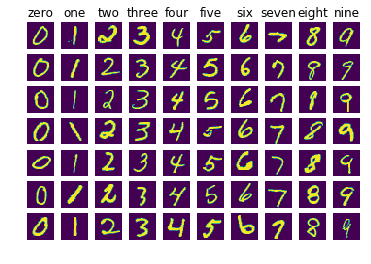

In [8]:
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
n_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Preprocess data

In [9]:
X_train = flatten2d(X_train)
X_test = flatten2d(X_test)
X_dev = flatten2d(X_dev)
# Preprocessing
# X_train, y_train, X_test, y_test = preprocess(X_train, y_train, X_test, y_test)
# mean_image = np.mean(X_train, axis=0)
# X_train = X_train - mean_image
# X_test = X_test - mean_image
# X_dev = X_dev - mean_image
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_dev = y_dev.astype(np.int32)
# y_train = y_train[..., None]
# y_test = y_test[..., None]
print(f"X_train.shape={X_train.shape}")
print(f"X_test.shape={X_test.shape}")
print(f"X_dev.shape={X_dev.shape}")
print(f"y_train.shape={y_train.shape}")
print(f"y_test.shape={y_test.shape}")
print(f"y_dev.shape={y_dev.shape}")

X_train.shape=(60000, 784)
X_test.shape=(10000, 784)
X_dev.shape=(500, 784)
y_train.shape=(60000,)
y_test.shape=(10000,)
y_dev.shape=(500,)


In [10]:
n_samples, n_features = X_train.shape
# n_classes = y_train.shape[1]
n_classes = np.max(y_train) + 1
n_dev = 500
print(f"n_samples={n_samples}, n_features={n_features}")
print(f"n_classes={n_classes}")

n_samples=60000, n_features=784
n_classes=10


Can also substract mean from train and test image

In [11]:
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_test -= mean_image

In [12]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

## Vectorized implementation

In [13]:
class SVM():
    
    def __init__(self, delta=1., reg=0.01):
        self.delta = delta
        self.reg = reg
       
    def loss(self, y, y_pred, w, train=True):
        """Return loss
        """
        n_samples = y.shape[0]
        correct_class_preds = y_pred[np.arange(n_samples), y][:, np.newaxis]
        margin = np.maximum(0, y_pred - correct_class_preds + self.delta)
        margin[np.arange(n_samples), y] = 0
        loss = margin.sum() / n_samples
        # Add regularization
        loss = loss + self.reg * np.sum(w * w)
        if train:
            self.margin = margin
        return loss
        
    def forward(self, X, w):
        """Perform forward pass
        """
        return np.dot(X, w)
    
    def accuracy(self, y, y_pred):
        if y_pred.ndim > 1:
            y_pred_flatten = np.argmax(y_pred, axis=1)
        else:
            y_pred_flatten = y_pred.copy()
            
        return (y == y_pred_flatten).sum() / y.shape[0]
    
    def backward(self, X, y, w):
        """Perform backprop
        """
        # We create a mask since the gradient of cost-sensitive multiclass loss is -x
        # for correct class and x for other classes
        n_samples = self.margin.shape[0]
        X_mask = np.zeros(self.margin.shape)
        X_mask[self.margin > 0] = 1 # We utilize classes that have greater than 0 margin
        valid_margin_count = X_mask.sum(axis=1) # Count how many classes have margin > 0
        X_mask[np.arange(n_samples), y] = -valid_margin_count
        dW = (np.dot(X.T, X_mask) / n_samples)
        dW = dW + 2 * self.reg * w
        return dW

## Analytical gradient check

In [14]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [15]:
w = np.random.randn(n_features + 1, n_classes)
svm = SVM()

In [16]:
pred = svm.forward(X_dev, w)
loss = svm.loss(y_dev, pred, w)
grad = svm.backward(X_dev, y_dev, w)
def f(w):
    p = svm.forward(X_dev, w)
    loss = svm.loss(y_dev, p, w, train=False)
    return loss
    
# f = lambda w: svm.loss(X_dev, y_dev, w, reg=5e1)[0]
grad_numerical = grad_check_sparse(f, w, grad)

NameError: name 'randrange' is not defined

## Train

In [17]:
w = np.random.randn(n_features + 1, n_classes) * 0.001
batch_size = 64
alpha = 1e-7
delta = 1.
reg = 0.01

svm = SVM(delta=delta, reg=reg)

In [18]:
# Iterate through number of samples
epochs = 2000
train_loss_history = []
test_loss_history = []
for epoch in range(epochs):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    # predict
    y_pred = svm.forward(X_batch, w)
    # Calculate loss
    train_loss = svm.loss(y_batch, y_pred, w)
    test_loss = svm.loss(y_test, svm.forward(X_test, w), w, train=False)
    # Calculate gradients
    dW = svm.backward(X_batch, y_batch, w)
    # Update parameters
    w = w - alpha * dW
    # Track loss
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch={epoch}/{epochs}: loss={train_loss:.4f}, test_loss={test_loss:.4f}")

Epoch=0/2000: loss=18.4362, test_loss=17.7314
Epoch=100/2000: loss=3.4551, test_loss=3.6264
Epoch=200/2000: loss=2.4476, test_loss=2.3266
Epoch=300/2000: loss=1.7472, test_loss=1.8205
Epoch=400/2000: loss=1.6419, test_loss=1.5536
Epoch=500/2000: loss=0.8785, test_loss=1.3762
Epoch=600/2000: loss=0.9829, test_loss=1.2630
Epoch=700/2000: loss=1.1716, test_loss=1.1789
Epoch=800/2000: loss=0.8611, test_loss=1.1053
Epoch=900/2000: loss=1.0041, test_loss=1.0563
Epoch=1000/2000: loss=0.8863, test_loss=1.0096
Epoch=1100/2000: loss=0.9111, test_loss=0.9711
Epoch=1200/2000: loss=0.9501, test_loss=0.9350
Epoch=1300/2000: loss=1.1528, test_loss=0.9121
Epoch=1400/2000: loss=1.0281, test_loss=0.8882
Epoch=1500/2000: loss=1.0989, test_loss=0.8639
Epoch=1600/2000: loss=1.5530, test_loss=0.8473
Epoch=1700/2000: loss=0.4798, test_loss=0.8255
Epoch=1800/2000: loss=1.3287, test_loss=0.8098
Epoch=1900/2000: loss=0.8803, test_loss=0.7924


## Evaluation

### Loss evaluation

Train loss

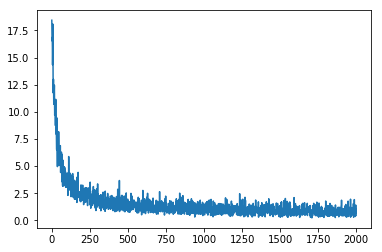

In [19]:
plt.plot(train_loss_history)

Test loss

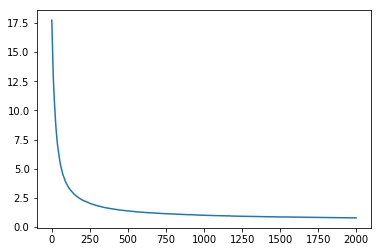

In [20]:
plt.plot(test_loss_history)

### Accuracy

In [21]:
y_train_preds = svm.forward(X_train, w)
y_test_preds = svm.forward(X_test, w)

In [24]:
train_acc = svm.accuracy(y_train, y_train_preds)
test_acc = svm.accuracy(y_test, y_test_preds)
print(f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

train_acc=0.8441, test_acc=0.8439
